In [46]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
#Neutralization

sr = SaltRemover() # from rdkit

In [3]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [5]:
smis=("c1cccc[nH+]1",
      "C[N+](C)(C)C","c1ccccc1[NH3+]",
      "CC(=O)[O-]","c1ccccc1[O-]",
      "CCS",
      "C[N-]S(=O)(=O)C",
      "C[N-]C=C","C[N-]N=C",
      "c1ccc[n-]1",
      "CC[N-]C(=O)CC")
for smi in smis:
    (molSmiles, neutralised) = NeutraliseCharges(Chem.MolFromSmiles(smi))
    print(smi + "->" + Chem.MolToSmiles(molSmiles))

c1cccc[nH+]1->c1ccncc1
C[N+](C)(C)C->C[N+](C)(C)C
c1ccccc1[NH3+]->Nc1ccccc1
CC(=O)[O-]->CC(=O)O
c1ccccc1[O-]->Oc1ccccc1
CCS->CCS
C[N-]S(=O)(=O)C->CNS(C)(=O)=O
C[N-]C=C->C=CNC
C[N-]N=C->C=NNC
c1ccc[n-]1->c1cc[nH]c1
CC[N-]C(=O)CC->CCNC(=O)CC


In [4]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [5]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]
# load mtor, we want to remember source of data and Standard and pChEMBLE value (it's transfomed compound activity to "standard" value)
with open("../bojicm/compound/chembl395.csv") as inp:
    mtor = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in mtor:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "hepg2"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [6]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = []
for m in Chem.SDMolSupplier("../data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue    
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
         "rdmol": m,
         "std_rdmol": stdmol,
         "source": "drugbank",
         "std_smiles": std_smiles,
         "Smiles": Chem.MolToSmiles(m),
         "pChEMBL Value": 0,
         "Standard Value": np.NaN,
         "fps": Chem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
         **{f[0]: f[1](stdmol) for f in lip_func}
        })


In [17]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *[m for m in mtor if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )


In [9]:
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,Standard Value,pChEMBL Value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f0c88bae350>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88baa710>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,29,...,0,0,3,3,0,0,0,0,0,0
1,1,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f0c88baa120>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88bc7d50>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,16,...,0,0,4,2,0,0,0,0,2,1
2,2,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b4f940>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b4f620>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN,0.00,15,...,0,0,1,2,0,0,0,1,0,0
3,3,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f0c88bc3c10>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88bc3800>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,16,...,0,0,1,5,0,0,0,0,2,1
4,4,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f0c88bc37b0>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88bc7440>,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN,0.00,12,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25657,25657,CCC(=O)NC1CCN(c2ccc(NC(=O)Nc3cc(OC)c(O)c4c3C[C...,CCC(=O)NC1CCN(c2ccc(NC(=O)Nc3cc(OC)c(O)c4c3C[C...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b8b210>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b95df0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28520.0,4.54,8,...,0,0,0,6,0,0,0,0,6,4
25658,25658,O=C1/C(=C/c2ccncc2)CNC/C1=C\c1ccccc1F,O=C1/C(=C/c2ccncc2)CNC/C1=C\c1ccccc1F,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b95f80>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b9b1c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8200.0,5.09,3,...,0,0,0,3,0,0,0,0,0,0
25659,25659,Cc1c(-c2ccn(Cc3ccc(OC(F)(F)F)cc3)n2)[nH]c2cccc...,Cc1c(-c2ccn(Cc3ccc(OC(F)(F)F)cc3)n2)[nH]c2cccc...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b9bd00>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba4c10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21200.0,4.67,4,...,0,0,1,3,0,0,0,0,2,1
25660,25660,C=C(C)[C@H]1Cc2c(ccc3c2O[C@@H]2COc4cc(OC)c(OC)...,C=C(C)[C@H]1Cc2c(ccc3c2O[C@@H]2COc4cc(OC)c(OC)...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba49e0>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba2f80>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1520.0,5.82,6,...,0,0,1,4,0,0,0,0,8,4


In [18]:
df = df[df['source']=='hepg2']

In [20]:
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,Standard Value,pChEMBL Value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6149,6149,O=[N+]([O-])c1cc(CSc2nnnn2C2CCCCC2)cc([N+](=O)...,O=[N+]([O-])c1cc(CSc2nnnn2C2CCCCC2)cc([N+](=O)...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c8e02be90>,<rdkit.Chem.rdchem.Mol object at 0x7f0c8e02b120>,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30000.0,0.00,9,...,0,0,1,2,0,0,0,0,0,0
6150,6150,O=[N+]([O-])c1cccc(-n2nnnc2SCc2cc([N+](=O)[O-]...,O=[N+]([O-])c1cccc(-n2nnnc2SCc2cc([N+](=O)[O-]...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6710>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6ad0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30000.0,0.00,11,...,0,0,1,2,0,0,0,0,0,0
6151,6151,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CCC(=O)C(C)...,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CCC(=O)C(C)...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6b70>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6f30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9050.0,5.04,3,...,0,0,0,5,0,0,0,0,8,4
6152,6152,Nc1cc(C(F)(F)F)c(-c2cc(N3CCOCC3)nc(N3CCOCC3)n2...,Nc1cc(C(F)(F)F)c(-c2cc(N3CCOCC3)nc(N3CCOCC3)n2...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8030>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba83f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3200.0,5.50,8,...,0,0,0,4,0,0,0,0,0,0
6153,6153,O=C1[C@@H]2[C@@H]3CC[C@@H](O3)[C@@H]2C(=O)N1c1...,O=C1[C@@H]2[C@@H]3CC[C@@H](O3)[C@@H]2C(=O)N1c1...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8490>,<rdkit.Chem.rdchem.Mol object at 0x7f0c8e02be40>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",28700.0,4.54,6,...,0,0,3,2,0,0,0,0,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25657,25657,CCC(=O)NC1CCN(c2ccc(NC(=O)Nc3cc(OC)c(O)c4c3C[C...,CCC(=O)NC1CCN(c2ccc(NC(=O)Nc3cc(OC)c(O)c4c3C[C...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b8b210>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b95df0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28520.0,4.54,8,...,0,0,0,6,0,0,0,0,6,4
25658,25658,O=C1/C(=C/c2ccncc2)CNC/C1=C\c1ccccc1F,O=C1/C(=C/c2ccncc2)CNC/C1=C\c1ccccc1F,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b95f80>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b9b1c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8200.0,5.09,3,...,0,0,0,3,0,0,0,0,0,0
25659,25659,Cc1c(-c2ccn(Cc3ccc(OC(F)(F)F)cc3)n2)[nH]c2cccc...,Cc1c(-c2ccn(Cc3ccc(OC(F)(F)F)cc3)n2)[nH]c2cccc...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b9bd00>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba4c10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21200.0,4.67,4,...,0,0,1,3,0,0,0,0,2,1
25660,25660,C=C(C)[C@H]1Cc2c(ccc3c2O[C@@H]2COc4cc(OC)c(OC)...,C=C(C)[C@H]1Cc2c(ccc3c2O[C@@H]2COc4cc(OC)c(OC)...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba49e0>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba2f80>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1520.0,5.82,6,...,0,0,1,4,0,0,0,0,8,4


In [21]:
df = df.rename(columns={'pChEMBL Value':'p_value', 'Standard Value':'std_value',
                       })

In [22]:
len(df)

19513

In [25]:
len(df[df['p_value'] > 0])

12195

In [26]:
len(df[df['std_value'] > 0])

18993

In [27]:
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,std_value,p_value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6149,6149,O=[N+]([O-])c1cc(CSc2nnnn2C2CCCCC2)cc([N+](=O)...,O=[N+]([O-])c1cc(CSc2nnnn2C2CCCCC2)cc([N+](=O)...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c8e02be90>,<rdkit.Chem.rdchem.Mol object at 0x7f0c8e02b120>,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30000.0,0.00,9,...,0,0,1,2,0,0,0,0,0,0
6150,6150,O=[N+]([O-])c1cccc(-n2nnnc2SCc2cc([N+](=O)[O-]...,O=[N+]([O-])c1cccc(-n2nnnc2SCc2cc([N+](=O)[O-]...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6710>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6ad0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30000.0,0.00,11,...,0,0,1,2,0,0,0,0,0,0
6151,6151,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CCC(=O)C(C)...,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CCC(=O)C(C)...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6b70>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6f30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9050.0,5.04,3,...,0,0,0,5,0,0,0,0,8,4
6152,6152,Nc1cc(C(F)(F)F)c(-c2cc(N3CCOCC3)nc(N3CCOCC3)n2...,Nc1cc(C(F)(F)F)c(-c2cc(N3CCOCC3)nc(N3CCOCC3)n2...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8030>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba83f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3200.0,5.50,8,...,0,0,0,4,0,0,0,0,0,0
6153,6153,O=C1[C@@H]2[C@@H]3CC[C@@H](O3)[C@@H]2C(=O)N1c1...,O=C1[C@@H]2[C@@H]3CC[C@@H](O3)[C@@H]2C(=O)N1c1...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8490>,<rdkit.Chem.rdchem.Mol object at 0x7f0c8e02be40>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",28700.0,4.54,6,...,0,0,3,2,0,0,0,0,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25657,25657,CCC(=O)NC1CCN(c2ccc(NC(=O)Nc3cc(OC)c(O)c4c3C[C...,CCC(=O)NC1CCN(c2ccc(NC(=O)Nc3cc(OC)c(O)c4c3C[C...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b8b210>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b95df0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28520.0,4.54,8,...,0,0,0,6,0,0,0,0,6,4
25658,25658,O=C1/C(=C/c2ccncc2)CNC/C1=C\c1ccccc1F,O=C1/C(=C/c2ccncc2)CNC/C1=C\c1ccccc1F,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b95f80>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b9b1c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8200.0,5.09,3,...,0,0,0,3,0,0,0,0,0,0
25659,25659,Cc1c(-c2ccn(Cc3ccc(OC(F)(F)F)cc3)n2)[nH]c2cccc...,Cc1c(-c2ccn(Cc3ccc(OC(F)(F)F)cc3)n2)[nH]c2cccc...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b9bd00>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba4c10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21200.0,4.67,4,...,0,0,1,3,0,0,0,0,2,1
25660,25660,C=C(C)[C@H]1Cc2c(ccc3c2O[C@@H]2COc4cc(OC)c(OC)...,C=C(C)[C@H]1Cc2c(ccc3c2O[C@@H]2COc4cc(OC)c(OC)...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba49e0>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba2f80>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1520.0,5.82,6,...,0,0,1,4,0,0,0,0,8,4


In [29]:
df.columns

Index(['index', 'Smiles', 'std_smiles', 'source', 'rdmol', 'std_rdmol', 'fps',
       'std_value', 'p_value', 'HBA', 'HBD', 'MW', 'LogP', 'TPSA', 'RB',
       'MQN_1', 'MQN_2', 'MQN_3', 'MQN_4', 'MQN_5', 'MQN_6', 'MQN_7', 'MQN_8',
       'MQN_9', 'MQN_10', 'MQN_11', 'MQN_12', 'MQN_13', 'MQN_14', 'MQN_15',
       'MQN_16', 'MQN_17', 'MQN_18', 'MQN_19', 'MQN_20', 'MQN_21', 'MQN_22',
       'MQN_23', 'MQN_24', 'MQN_25', 'MQN_26', 'MQN_27', 'MQN_28', 'MQN_29',
       'MQN_30', 'MQN_31', 'MQN_32', 'MQN_33', 'MQN_34', 'MQN_35', 'MQN_36',
       'MQN_37', 'MQN_38', 'MQN_39', 'MQN_40', 'MQN_41', 'MQN_42'],
      dtype='object')

- We will be using Random forest, SVR and Adaboost to find which forms give best prediction for desired activity. 
- HBA, HBD, MW, LogP, TPSA, RB columns are used.
- They are divided into a test, training and validation set.

# **RANDOM FOREST**

### _'HBA' 'HBD', 'MW', 'LogP', 'TPSA', 'RB'_

In [58]:
data = df[['HBA', 'HBD', 'MW', 'LogP', 'TPSA', 'RB', 'p_value']]
data = data[data['p_value']>0]
data

,HBA,HBD,MW,LogP,TPSA,RB,p_value
6151,3,1,524.434179,6.89090,49.41,4,5.04
6152,8,1,410.167809,1.81280,89.63,3,5.50
6153,6,0,392.104207,0.37430,93.22,3,4.54
6154,8,1,448.163436,2.76720,99.88,3,6.58
6156,6,0,445.171417,5.13792,57.76,6,5.01
...,...,...,...,...,...,...,...
25657,8,4,697.308719,6.32790,124.63,8,4.54
25658,3,1,294.116841,2.86000,41.99,2,5.09
25659,4,1,399.119461,4.64692,59.91,4,4.67
25660,6,0,394.141638,3.70330,63.22,3,5.82


In [43]:
df.iloc[:,3]

6149     hepg2
6150     hepg2
6151     hepg2
6152     hepg2
6153     hepg2
         ...  
25657    hepg2
25658    hepg2
25659    hepg2
25660    hepg2
25661    hepg2
Name: source, Length: 19513, dtype: object

In [62]:
n_splits = 5


X_train, X_test, y_train, y_test = train_test_split(data[['HBA', 'HBD', 'MW', 'LogP', 'TPSA', 'RB']],data['p_value'], test_size=0.3, random_state=0)  


kf = KFold(n_splits = n_splits, shuffle=True, random_state=0)
a = -1 

param_gridRan = {
    "n_estimators": range(1,100,5),
    "max_depth": range(1,10)
}

mse = 1
for trains, valids in kf.split(X_train, y_train):
    a = a+1
    train_x = X_train.iloc[trains].values.tolist()
    train_y = y_train.iloc[trains].values.tolist()
    valid_x = X_train.iloc[valids].values.tolist()
    valid_y = y_train.iloc[valids].values.tolist()
    
    
    param_comb = ParameterGrid(param_gridRan)
    for params in param_comb:
        rfc = RandomForestRegressor(**params)
        rfc = rfc.fit(train_x,train_y)
        pre_rfc = rfc.predict(valid_x)

        mse1=  mean_squared_error(valid_y, rfc.predict(valid_x))
        if mse > mse1:
            mse = mse1
            opt_param = params

print("Valid MSE", mse)
print("Optimal parameter Random Forest", opt_param)

Valid MSE 0.592623784835568
Optimal parameter Random Forest {'max_depth': 9, 'n_estimators': 16}


In [65]:
X = X_train.values.tolist()
y = y_train.values.tolist()

x_pred = X_test.values.tolist()
y_real = y_test.values.tolist()

rfr = RandomForestRegressor(**opt_param)
rfr.fit(X, y)

print("Test MSE")
print("MSE: %0.2f" % mean_squared_error(y_real, rfc.predict(x_pred)))
print("Regressor score:", rfr.score(x_pred, y_real))
print("R^2", r2_score(y_real, rfc.predict(x_pred)))

Test MSE
MSE: 0.64
Regressor score: 0.17425023036035903
R^2 0.18907615875992956


In [66]:
test = pd.DataFrame()
test['Prediction'] = rfc.predict(x_pred)
test['Real'] = y_real
test

,Prediction,Real
0,5.036506,5.10
1,5.137403,5.41
2,5.190722,6.54
3,5.885870,6.27
4,5.275617,6.62
...,...,...
3654,5.220303,4.73
3655,4.841368,4.16
3656,5.270554,5.11
3657,4.861883,4.33


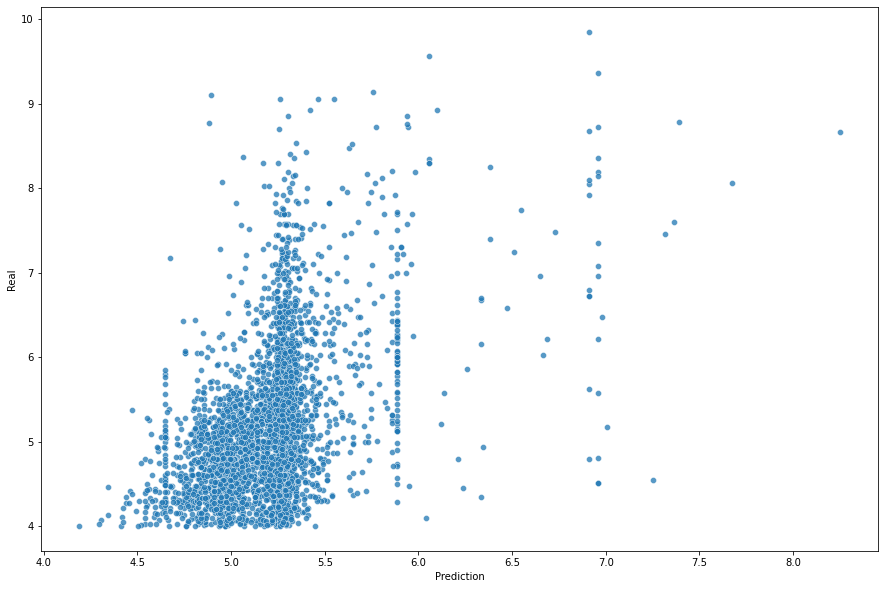

In [67]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Real",
                      data=test,                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### _MQN_

In [69]:
df = df[df['p_value']>0]
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,std_value,p_value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6151,6151,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CCC(=O)C(C)...,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CCC(=O)C(C)...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6b70>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6f30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9050.0,5.04,3,...,0,0,0,5,0,0,0,0,8,4
6152,6152,Nc1cc(C(F)(F)F)c(-c2cc(N3CCOCC3)nc(N3CCOCC3)n2...,Nc1cc(C(F)(F)F)c(-c2cc(N3CCOCC3)nc(N3CCOCC3)n2...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8030>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba83f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3200.0,5.50,8,...,0,0,0,4,0,0,0,0,0,0
6153,6153,O=C1[C@@H]2[C@@H]3CC[C@@H](O3)[C@@H]2C(=O)N1c1...,O=C1[C@@H]2[C@@H]3CC[C@@H](O3)[C@@H]2C(=O)N1c1...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8490>,<rdkit.Chem.rdchem.Mol object at 0x7f0c8e02be40>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",28700.0,4.54,6,...,0,0,3,2,0,0,0,0,5,3
6154,6154,CCOC1CCc2c(ccc3nc4c(cc23)Cn2c-4cc3c(c2=O)COC(=...,CCOC1CCc2c(ccc3nc4c(cc23)Cn2c-4cc3c(c2=O)COC(=...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba88a0>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8c60>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",265.0,6.58,8,...,0,0,1,5,0,0,0,0,10,5
6156,6156,COc1ccc2c3ccnc(C)c3n(Cc3cn(C/C=C/c4ccc(F)c(F)c...,COc1ccc2c3ccnc(C)c3n(Cc3cn(C/C=C/c4ccc(F)c(F)c...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8b70>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba85d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9750.0,5.01,6,...,0,0,2,3,0,0,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25657,25657,CCC(=O)NC1CCN(c2ccc(NC(=O)Nc3cc(OC)c(O)c4c3C[C...,CCC(=O)NC1CCN(c2ccc(NC(=O)Nc3cc(OC)c(O)c4c3C[C...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b8b210>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b95df0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28520.0,4.54,8,...,0,0,0,6,0,0,0,0,6,4
25658,25658,O=C1/C(=C/c2ccncc2)CNC/C1=C\c1ccccc1F,O=C1/C(=C/c2ccncc2)CNC/C1=C\c1ccccc1F,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b95f80>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b9b1c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8200.0,5.09,3,...,0,0,0,3,0,0,0,0,0,0
25659,25659,Cc1c(-c2ccn(Cc3ccc(OC(F)(F)F)cc3)n2)[nH]c2cccc...,Cc1c(-c2ccn(Cc3ccc(OC(F)(F)F)cc3)n2)[nH]c2cccc...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b9bd00>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba4c10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21200.0,4.67,4,...,0,0,1,3,0,0,0,0,2,1
25660,25660,C=C(C)[C@H]1Cc2c(ccc3c2O[C@@H]2COc4cc(OC)c(OC)...,C=C(C)[C@H]1Cc2c(ccc3c2O[C@@H]2COc4cc(OC)c(OC)...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba49e0>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba2f80>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1520.0,5.82,6,...,0,0,1,4,0,0,0,0,8,4


In [70]:
a = ['MQN_{}'.format(x) for x in range(1,43)]

In [71]:
data_mqn = df[a]
data_mqn

,MQN_1,MQN_2,MQN_3,MQN_4,MQN_5,MQN_6,MQN_7,MQN_8,MQN_9,MQN_10,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6151,34,0,0,0,0,0,0,2,0,2,...,0,0,0,5,0,0,0,0,8,4
6152,18,3,0,0,0,0,0,1,5,0,...,0,0,0,4,0,0,0,0,0,0
6153,18,0,0,0,0,1,0,0,2,4,...,0,0,3,2,0,0,0,0,5,3
6154,25,0,0,0,0,0,0,0,2,4,...,0,0,1,5,0,0,0,0,10,5
6156,25,2,0,0,0,0,0,0,5,1,...,0,0,2,3,0,0,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25657,36,3,0,0,0,0,0,3,2,6,...,0,0,0,6,0,0,0,0,6,4
25658,18,1,0,0,0,0,0,0,2,1,...,0,0,0,3,0,0,0,0,0,0
25659,21,3,0,0,0,0,0,0,3,2,...,0,0,1,3,0,0,0,0,2,1
25660,23,0,0,0,0,0,0,0,0,3,...,0,0,1,4,0,0,0,0,8,4


In [72]:
data_p = df[['p_value']]
data_p

,p_value
6151,5.04
6152,5.50
6153,4.54
6154,6.58
6156,5.01
...,...
25657,4.54
25658,5.09
25659,4.67
25660,5.82


In [73]:
X = data_mqn
y = data_p

In [74]:

n_splits = 5

X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.3, random_state=0)  


kf = KFold(n_splits = n_splits, shuffle=True, random_state=0)
a = -1 

param_gridRan = {
    "n_estimators": range(1,100,5),
    "max_depth": range(1,10)
}

mse = 1
for trains, valids in kf.split(X_train, y_train):
    a = a+1
    train_x = X_train.iloc[trains]
    train_y = y_train.iloc[trains]
    valid_x = X_train.iloc[valids]
    valid_y = y_train.iloc[valids]
    
    
    param_comb = ParameterGrid(param_gridRan)
    for params in param_comb:
        rfc = RandomForestRegressor(**params)
        rfc = rfc.fit(train_x,train_y)
        pre_rfc = rfc.predict(valid_x)

        mse1=  mean_squared_error(valid_y, rfc.predict(valid_x))
        if mse > mse1:
            mse = mse1
            opt_param = params

print("Valid MSE", mse)
print("Optimal parameter for Random Forest", opt_param)

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/milan/miniconda3/envs/cdd/lib/

Valid MSE 0.483998627451938
Optimalni_parametr pro Random Forest {'max_depth': 9, 'n_estimators': 26}


In [75]:
y_test

,p_value
15656,5.10
14467,5.41
12131,6.54
21363,6.27
19849,6.62
...,...
8003,4.73
24134,4.16
23071,5.11
23398,4.33


In [76]:
X = X_train
y = y_train

x_pred = X_test
y_real = y_test

rfr = RandomForestRegressor(**opt_param)
rfr.fit(X, y)

print("Test MSE")
print("MSE: %0.2f" % mean_squared_error(y_real, rfc.predict(x_pred)))
print("Regressor score:", rfr.score(x_pred, y_real))
print("R^2", r2_score(y_real, rfc.predict(x_pred)))

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Test MSE
MSE: 0.54
Regressor score: 0.30261440859424116
R^2 0.308937226215089


In [77]:
y_real = y_real.to_numpy()

In [78]:
test = pd.DataFrame()
test['Prediction'] = rfc.predict(x_pred)
test['Real'] = y_real
test

,Prediction,Real
0,4.986060,5.10
1,5.419484,5.41
2,5.490075,6.54
3,5.807540,6.27
4,5.493193,6.62
...,...,...
3654,4.900298,4.73
3655,4.733107,4.16
3656,5.178827,5.11
3657,4.898784,4.33


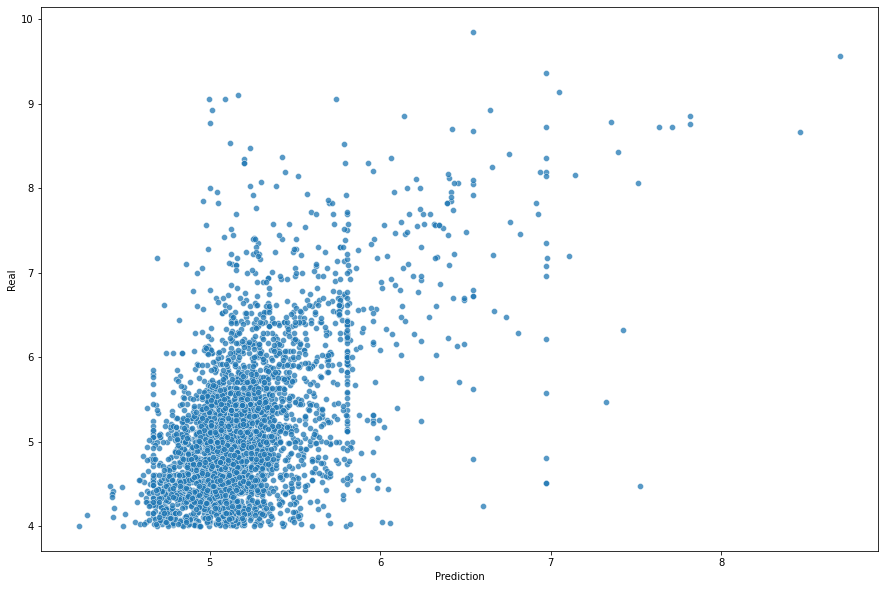

In [79]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Real",
                      data=test,                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Both predictions are not showing satisfying results, but random forest with MQN is slightly better.

# **SVR**

### _'HBA' 'HBD', 'MW', 'LogP', 'TPSA', 'RB'_

In [93]:
df = df[df['p_value']>0]
data = df[['HBA', 'HBD', 'MW', 'LogP', 'TPSA', 'RB', 'p_value']]
data = data[data['p_value']>0]
data

,HBA,HBD,MW,LogP,TPSA,RB,p_value
6151,3,1,524.434179,6.89090,49.41,4,5.04
6152,8,1,410.167809,1.81280,89.63,3,5.50
6153,6,0,392.104207,0.37430,93.22,3,4.54
6154,8,1,448.163436,2.76720,99.88,3,6.58
6156,6,0,445.171417,5.13792,57.76,6,5.01
...,...,...,...,...,...,...,...
25657,8,4,697.308719,6.32790,124.63,8,4.54
25658,3,1,294.116841,2.86000,41.99,2,5.09
25659,4,1,399.119461,4.64692,59.91,4,4.67
25660,6,0,394.141638,3.70330,63.22,3,5.82


In [96]:
svr = svm.SVR(kernel = 'rbf') # try to put rbf

In [101]:
n_splits = 5

X_train, X_test, y_train, y_test = train_test_split(data[['HBA', 'HBD', 'MW', 'LogP', 'TPSA', 'RB']],data['p_value'] ,test_size=0.3, random_state=0)  


kf = KFold(n_splits = n_splits, shuffle=True, random_state=0)
a = -1 

param_gridSVR = {
    "kernel":['linear', 'poly', 'rbf', 'sigmoid']
}

mse = 1
for trains, valids in kf.split(X_train, y_train):
    a = a+1
    train_x = X_train.iloc[trains].values.tolist()
    train_y = y_train.iloc[trains].values.tolist()
    valid_x = X_train.iloc[valids].values.tolist()
    valid_y = y_train.iloc[valids].values.tolist()
    
    
    param_comb = ParameterGrid(param_gridSVR)
    for params in param_comb:
        
        svr = svm.SVR(**params)
        svr = svr.fit(train_x,train_y)
        pre_svr = svr.predict(valid_x)

        mse1=  mean_squared_error(valid_y, svr.predict(valid_x))
        if mse > mse1:
            mse = mse1
            opt_param = params

print("Valid MSE", mse)
print("Optimal parameter for Random Forest", opt_param)

Valid MSE 0.7621811042547562
Optimal parameter for Random Forest {'kernel': 'rbf'}


In [104]:
X = X_train.values.tolist()
y = y_train.values.tolist()

x_pred = X_test.values.tolist()
y_real = y_test.values.tolist()

svr = svm.SVR(**opt_param)
svr.fit(X, y)

print("Test MSE")
print("MSE: %0.2f" % mean_squared_error(y_real, svr.predict(x_pred)))
print("Regressor score:", svr.score(x_pred, y_real))
print("R^2", r2_score(y_real, svr.predict(x_pred)))

Test MSE
MSE: 0.80
Regressor score: -0.015033027405856991
R^2 -0.015033027405856991


In [108]:
print(len(x_pred))

3659


In [109]:
print(len(y_real))

3659


In [106]:
x_pred

[[3.0, 1.0, 351.00968042399995, 5.5085200000000025, 37.81, 2.0],
 [5.0, 3.0, 315.1331394040001, 2.58612, 104.91999999999999, 4.0],
 [10.0, 2.0, 541.1245054399999, 2.658100000000001, 189.36, 6.0],
 [12.0, 6.0, 543.1740607479999, 0.0012999999999993017, 206.07, 5.0],
 [7.0, 1.0, 431.18450627999994, 3.3998000000000017, 86.79, 4.0],
 [5.0, 1.0, 377.21032710400004, 4.1868000000000025, 46.620000000000005, 7.0],
 [17.0, 6.0, 1023.5910654919999, 4.745000000000011, 223.1, 15.0],
 [4.0, 4.0, 660.4866085279999, 7.38680000000001, 98.66000000000001, 5.0],
 [7.0, 1.0, 384.17841785599995, 2.6024000000000003, 100.52000000000002, 4.0],
 [8.0, 3.0, 550.153159148, 5.497800000000004, 118.99000000000001, 8.0],
 [5.0, 1.0, 457.14601259600005, 4.851500000000004, 84.98999999999998, 5.0],
 [9.0, 2.0, 596.1902454919999, 7.1778000000000075, 110.13, 11.0],
 [2.0, 3.0, 397.08048906000005, 4.762000000000002, 70.23, 4.0],
 [7.0, 3.0, 343.0167680279999, 0.11371999999999949, 100.63000000000001, 2.0],
 [5.0, 1.0, 500.35

In [110]:
y_real

[5.1,
 5.41,
 6.54,
 6.27,
 6.62,
 5.34,
 4.75,
 4.75,
 4.4,
 4.54,
 4.56,
 4.57,
 4.69,
 5.26,
 4.69,
 5.71,
 4.69,
 4.69,
 5.13,
 4.78,
 4.4,
 4.97,
 4.97,
 6.58,
 4.39,
 5.07,
 6.43,
 4.89,
 6.0,
 4.58,
 6.64,
 5.16,
 5.48,
 4.33,
 4.51,
 5.49,
 4.31,
 4.85,
 4.32,
 6.47,
 4.56,
 8.0,
 4.62,
 4.11,
 4.13,
 4.58,
 4.73,
 4.79,
 4.3,
 4.58,
 4.64,
 5.21,
 6.05,
 6.44,
 6.57,
 4.08,
 4.51,
 4.71,
 4.51,
 5.25,
 5.25,
 4.7,
 5.99,
 5.51,
 4.91,
 6.23,
 5.17,
 6.19,
 4.58,
 5.42,
 6.36,
 4.17,
 4.78,
 4.61,
 4.09,
 5.09,
 4.64,
 6.13,
 7.1,
 4.59,
 5.55,
 4.76,
 4.79,
 4.7,
 4.15,
 5.18,
 7.85,
 7.25,
 5.3,
 5.25,
 4.41,
 4.42,
 6.51,
 4.33,
 5.27,
 4.47,
 5.01,
 5.42,
 5.48,
 4.6,
 5.03,
 7.56,
 5.92,
 5.21,
 4.33,
 5.89,
 4.6,
 5.13,
 4.97,
 4.72,
 4.83,
 5.29,
 4.83,
 4.73,
 6.28,
 5.1,
 4.8,
 5.27,
 5.65,
 4.71,
 4.55,
 4.01,
 5.24,
 4.28,
 5.37,
 6.32,
 4.35,
 4.49,
 5.51,
 4.93,
 4.8,
 4.7,
 5.37,
 5.32,
 5.08,
 5.37,
 4.78,
 4.05,
 6.61,
 4.81,
 5.85,
 6.64,
 5.89,
 5.01,
 7.09,
 

In [112]:
svr.predict(x_pred)

array([4.92757028, 4.91143893, 5.34373595, ..., 5.11061795, 4.98626123,
       4.95569957])

In [113]:
test = pd.DataFrame()
test['Prediction'] = svr.predict(x_pred)
test['Real'] = y_real
test

,Prediction,Real
0,4.927570,5.10
1,4.911439,5.41
2,5.343736,6.54
3,5.390902,6.27
4,5.061447,6.62
...,...,...
3654,5.050400,4.73
3655,5.005861,4.16
3656,5.110618,5.11
3657,4.986261,4.33


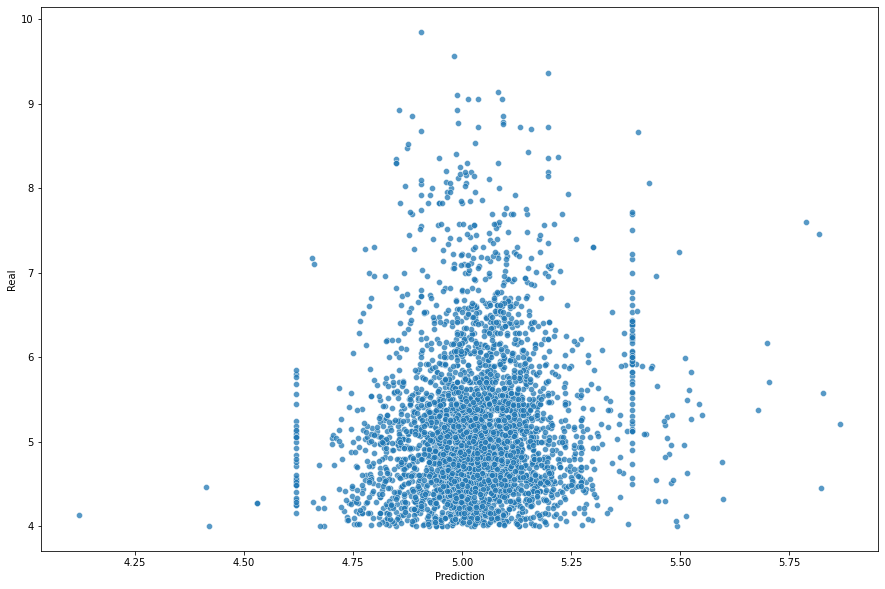

In [114]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Real",
                      data=test,                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## *MQN*

In [115]:
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,std_value,p_value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6151,6151,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CCC(=O)C(C)...,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CCC(=O)C(C)...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6b70>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba6f30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9050.0,5.04,3,...,0,0,0,5,0,0,0,0,8,4
6152,6152,Nc1cc(C(F)(F)F)c(-c2cc(N3CCOCC3)nc(N3CCOCC3)n2...,Nc1cc(C(F)(F)F)c(-c2cc(N3CCOCC3)nc(N3CCOCC3)n2...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8030>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba83f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3200.0,5.50,8,...,0,0,0,4,0,0,0,0,0,0
6153,6153,O=C1[C@@H]2[C@@H]3CC[C@@H](O3)[C@@H]2C(=O)N1c1...,O=C1[C@@H]2[C@@H]3CC[C@@H](O3)[C@@H]2C(=O)N1c1...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8490>,<rdkit.Chem.rdchem.Mol object at 0x7f0c8e02be40>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",28700.0,4.54,6,...,0,0,3,2,0,0,0,0,5,3
6154,6154,CCOC1CCc2c(ccc3nc4c(cc23)Cn2c-4cc3c(c2=O)COC(=...,CCOC1CCc2c(ccc3nc4c(cc23)Cn2c-4cc3c(c2=O)COC(=...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba88a0>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8c60>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",265.0,6.58,8,...,0,0,1,5,0,0,0,0,10,5
6156,6156,COc1ccc2c3ccnc(C)c3n(Cc3cn(C/C=C/c4ccc(F)c(F)c...,COc1ccc2c3ccnc(C)c3n(Cc3cn(C/C=C/c4ccc(F)c(F)c...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba8b70>,<rdkit.Chem.rdchem.Mol object at 0x7f0c89ba85d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9750.0,5.01,6,...,0,0,2,3,0,0,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25657,25657,CCC(=O)NC1CCN(c2ccc(NC(=O)Nc3cc(OC)c(O)c4c3C[C...,CCC(=O)NC1CCN(c2ccc(NC(=O)Nc3cc(OC)c(O)c4c3C[C...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b8b210>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b95df0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28520.0,4.54,8,...,0,0,0,6,0,0,0,0,6,4
25658,25658,O=C1/C(=C/c2ccncc2)CNC/C1=C\c1ccccc1F,O=C1/C(=C/c2ccncc2)CNC/C1=C\c1ccccc1F,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b95f80>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b9b1c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8200.0,5.09,3,...,0,0,0,3,0,0,0,0,0,0
25659,25659,Cc1c(-c2ccn(Cc3ccc(OC(F)(F)F)cc3)n2)[nH]c2cccc...,Cc1c(-c2ccn(Cc3ccc(OC(F)(F)F)cc3)n2)[nH]c2cccc...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88b9bd00>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba4c10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21200.0,4.67,4,...,0,0,1,3,0,0,0,0,2,1
25660,25660,C=C(C)[C@H]1Cc2c(ccc3c2O[C@@H]2COc4cc(OC)c(OC)...,C=C(C)[C@H]1Cc2c(ccc3c2O[C@@H]2COc4cc(OC)c(OC)...,hepg2,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba49e0>,<rdkit.Chem.rdchem.Mol object at 0x7f0c88ba2f80>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1520.0,5.82,6,...,0,0,1,4,0,0,0,0,8,4


In [116]:
a = ['MQN_{}'.format(x) for x in range(1,43)]

In [117]:
data_mqn = df[a]
data_mqn

,MQN_1,MQN_2,MQN_3,MQN_4,MQN_5,MQN_6,MQN_7,MQN_8,MQN_9,MQN_10,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6151,34,0,0,0,0,0,0,2,0,2,...,0,0,0,5,0,0,0,0,8,4
6152,18,3,0,0,0,0,0,1,5,0,...,0,0,0,4,0,0,0,0,0,0
6153,18,0,0,0,0,1,0,0,2,4,...,0,0,3,2,0,0,0,0,5,3
6154,25,0,0,0,0,0,0,0,2,4,...,0,0,1,5,0,0,0,0,10,5
6156,25,2,0,0,0,0,0,0,5,1,...,0,0,2,3,0,0,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25657,36,3,0,0,0,0,0,3,2,6,...,0,0,0,6,0,0,0,0,6,4
25658,18,1,0,0,0,0,0,0,2,1,...,0,0,0,3,0,0,0,0,0,0
25659,21,3,0,0,0,0,0,0,3,2,...,0,0,1,3,0,0,0,0,2,1
25660,23,0,0,0,0,0,0,0,0,3,...,0,0,1,4,0,0,0,0,8,4


In [118]:
data_p = df[['p_value']]
data_p

,p_value
6151,5.04
6152,5.50
6153,4.54
6154,6.58
6156,5.01
...,...
25657,4.54
25658,5.09
25659,4.67
25660,5.82


In [119]:
X = data_mqn
y = data_p

In [121]:
n_splits = 5

X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.3, random_state=0)  


kf = KFold(n_splits = n_splits, shuffle=True, random_state=0)
a = -1 

param_gridSVR = {
    "kernel":['linear', 'poly', 'rbf', 'sigmoid']
}

mse = 1
for trains, valids in kf.split(X_train, y_train):
    a = a+1
    train_x = X_train.iloc[trains]
    train_y = y_train.iloc[trains]
    valid_x = X_train.iloc[valids]
    valid_y = y_train.iloc[valids]
    
    
    param_comb = ParameterGrid(param_gridSVR)
    for params in param_comb:
        
        svr = svm.SVR(**params)
        svr = svr.fit(train_x,train_y)
        pre_svr = svr.predict(valid_x)

        mse1=  mean_squared_error(valid_y, svr.predict(valid_x))
        if mse > mse1:
            mse = mse1
            opt_param = params

print("Valid MSE", mse)
print("Optimal parameter for Random Forest", opt_param)

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected

Valid MSE 0.6932155587147588
Optimal parameter for Random Forest {'kernel': 'rbf'}


In [122]:
X = X_train
y = y_train

x_pred = X_test
y_real = y_test

svr = svm.SVR(**opt_param)
svr.fit(X, y)

print("Test MSE")
print("MSE: %0.2f" % mean_squared_error(y_real, svr.predict(x_pred)))
print("Regressor score:", svr.score(x_pred, y_real))
print("R^2", r2_score(y_real, svr.predict(x_pred)))

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Test MSE
MSE: 0.73
Regressor score: 0.07095071571554756
R^2 0.07095071571554756


In [123]:
y_real = y_real.to_numpy()

In [124]:
test = pd.DataFrame()
test['Prediction'] = svr.predict(x_pred)
test['Real'] = y_real
test

,Prediction,Real
0,4.799794,5.10
1,4.922007,5.41
2,5.402059,6.54
3,5.690134,6.27
4,5.289912,6.62
...,...,...
3654,4.762779,4.73
3655,4.612671,4.16
3656,5.086088,5.11
3657,4.865484,4.33


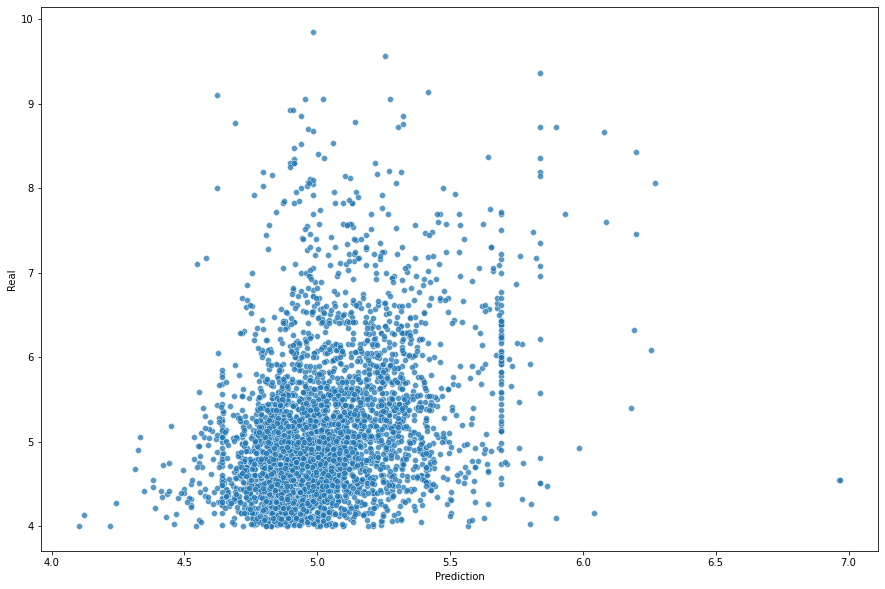

In [126]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Real",
                      data=test,                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Both models give subpar predictions. As Milan V. quoted: _"Both are rubish..."_

# AdaBoost

In [127]:
data = df[['HBA', 'HBD', 'MW', 'LogP', 'TPSA', 'RB', 'p_value']]
data

,HBA,HBD,MW,LogP,TPSA,RB,p_value
6151,3,1,524.434179,6.89090,49.41,4,5.04
6152,8,1,410.167809,1.81280,89.63,3,5.50
6153,6,0,392.104207,0.37430,93.22,3,4.54
6154,8,1,448.163436,2.76720,99.88,3,6.58
6156,6,0,445.171417,5.13792,57.76,6,5.01
...,...,...,...,...,...,...,...
25657,8,4,697.308719,6.32790,124.63,8,4.54
25658,3,1,294.116841,2.86000,41.99,2,5.09
25659,4,1,399.119461,4.64692,59.91,4,4.67
25660,6,0,394.141638,3.70330,63.22,3,5.82


In [128]:
X_train, X_test, y_train, y_test = train_test_split(data[['HBA', 'HBD', 'MW', 'LogP', 'TPSA', 'RB']],data['p_value'] ,test_size=0.3, random_state=0)

In [130]:
X = X_train.values.tolist()
y = y_train.values.tolist()

x_pred = X_test.values.tolist()
y_real = y_test.values.tolist()

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X, y)

print("Test MSE")
print("MSE: %0.2f" % mean_squared_error(y_real, regr.predict(x_pred)))
print("Regressor score:", regr.score(x_pred, y_real))
print("R^2", r2_score(y_real, regr.predict(x_pred)))

Test MSE
MSE: 1.06
Regressor score: -0.3517326455418488
R^2 -0.3517326455418488


In [131]:
test = pd.DataFrame()
test['Prediction'] = regr.predict(x_pred)
test['Real'] = y_real
test

,Prediction,Real
0,5.741223,5.10
1,5.748352,5.41
2,5.767224,6.54
3,5.748158,6.27
4,5.452608,6.62
...,...,...
3654,5.748352,4.73
3655,5.193122,4.16
3656,5.567890,5.11
3657,5.193122,4.33


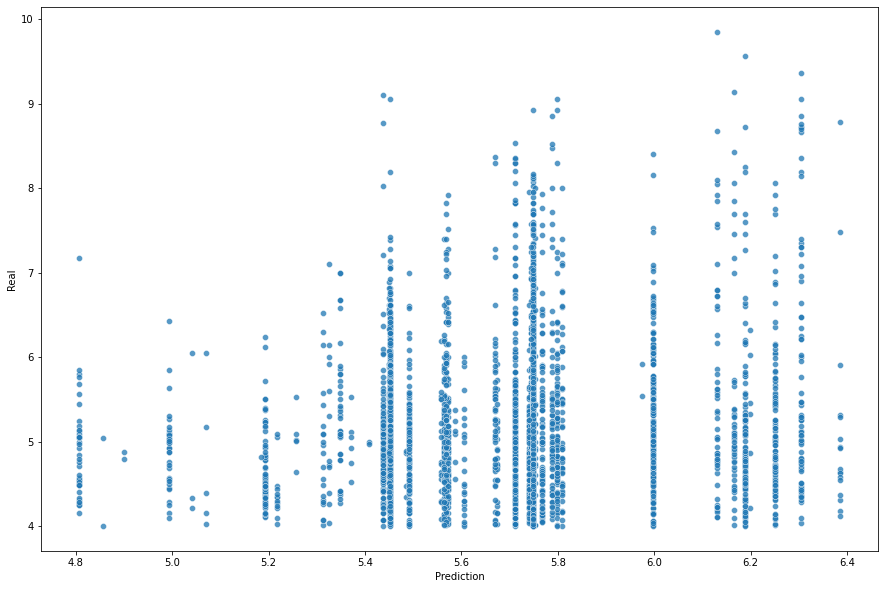

In [132]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Real",
                      data=test,                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

AdaBoost didn't show improved results, one could say it's even worse than SVR and random forest.